# C1 W1 Group 8

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import seaborn as sns
import pandas as pd
import cv2

from src.data import GT_QSD1_W2_LIST
from src.paths import BBDD_PATH, QSD1_W2_PATH, QSD2_W2_PATH, QST1_W2_PATH, QST2_W2_PATH, WEEK_2_RESULTS_PATH
from src.descriptors import GreyScaleHistogramDescriptor1D, ColorHistogramDescriptor1D, MultiColorSpaceHistogramDescriptor1D
from src.similarities import MSE, L1Distance, ChiSquaredDistance, HistogramIntersection, HellingerKernel, Bhattacharyya
from src.metrics import MeanAveragePrecisionAtK
import pickle
from tqdm import tqdm

## Task 3 - 
For each image in the QS2, remove background using the background color:
- Create a binary mask to evaluate the method
- Compute the descriptors on the foreground pixels

In [3]:
query_image_PIL_list = [Image.open(db_img_path) for db_img_path in sorted(QSD2_W2_PATH.glob("*.jpg"))]  # Load once
for idx, db_img in enumerate(query_image_PIL_list):
    assert db_img.filename.endswith(f"{idx}.jpg")

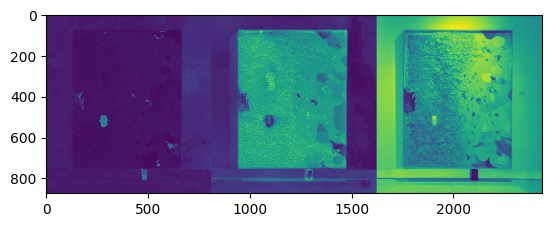

In [4]:
img = query_image_PIL_list[3]
image_np = np.array(img)

hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

plt.imshow(np.concatenate((h,s,v),axis=1))

We can see that H is not really meaningful.
Lets see histogram distribution of both S and V

In [5]:
border_size = 10

borders = [
    hsv_image[:border_size, :, :], 
    hsv_image[-border_size:, :, :], 
    hsv_image[:, :border_size, :], 
    hsv_image[:, -border_size:, :] 
]
border_pixels = np.vstack([border.reshape(-1, 3) for border in borders])

In [6]:
def find_best_threshold(set1, set2):
    combined = np.sort(np.concatenate((set1, set2)))
    thresholds = (combined[:-1] + combined[1:]) / 2
    counts1 = np.searchsorted(combined, thresholds, side='right')
    counts2 = len(set2) - counts1
    means = np.mean(set1), np.mean(set2)
    
    scores = np.abs((means[0] * counts1 + means[1] * counts2) / (counts1 + counts2) - 
                    (means[0] * counts2 + means[1] * counts1) / (counts1 + counts2))
    
    best_threshold = int(thresholds[np.argmax(scores)])
    
    if means[1] < means[0]:  
        return best_threshold, 255  
    else:
        return 0, best_threshold  

img_without_10 = hsv_image[10:-10,10:-10,:].reshape(-1, 3)

h_thresh = find_best_threshold(img_without_10[:,0],border_pixels[:,0])
s_thresh = find_best_threshold(img_without_10[:,1],border_pixels[:,1])
v_thresh = find_best_threshold(img_without_10[:,2],border_pixels[:,2])

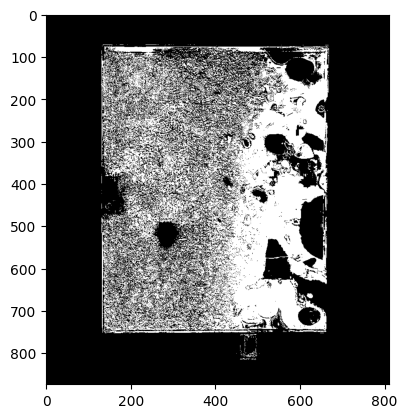

In [7]:
upper = (hsv_image[:,:,1]>s_thresh[0]).astype(np.uint8) 
lower = (hsv_image[:,:,1]<s_thresh[1]).astype(np.uint8) 

mask_s = cv2.bitwise_and(upper,lower).astype(float)
plt.imshow(mask_s,cmap=plt.cm.gray)

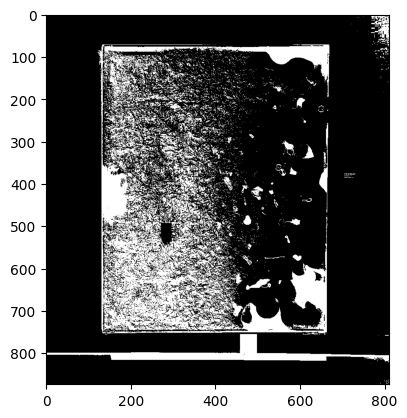

In [8]:
upper = (hsv_image[:,:,2]>v_thresh[0]).astype(np.uint8)
lower = (hsv_image[:,:,2]<v_thresh[1]).astype(np.uint8)

mask_v = cv2.bitwise_and(upper,lower).astype(float)
plt.imshow(mask_v,cmap=plt.cm.gray)

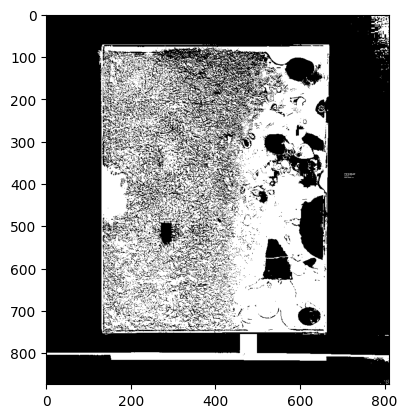

In [9]:
mask = cv2.bitwise_or(mask_v,mask_s).astype(float)

plt.imshow(mask,cmap=plt.cm.gray)

In [16]:
def generate_mask(PIL_img):
    image_np = np.array(PIL_img)
    hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

    border_size = 10

    borders = [
        hsv_image[:border_size, :, :], 
        hsv_image[-border_size:, :, :], 
        hsv_image[:, :border_size, :], 
        hsv_image[:, -border_size:, :] 
    ]
    border_pixels = np.vstack([border.reshape(-1, 3) for border in borders])

    img_without_10 = hsv_image[10:-10,10:-10,:].reshape(-1, 3)

    # h_thresh = find_best_threshold(img_without_10[:,0],border_pixels[:,0])
    s_thresh = find_best_threshold(img_without_10[:,1],border_pixels[:,1])
    v_thresh = find_best_threshold(img_without_10[:,2],border_pixels[:,2])


    upper = (hsv_image[:,:,1]>s_thresh[0]).astype(np.uint8) 
    lower = (hsv_image[:,:,1]<s_thresh[1]).astype(np.uint8) 

    mask_s = cv2.bitwise_and(upper,lower).astype(float)

    upper = (hsv_image[:,:,2]>v_thresh[0]).astype(np.uint8) 
    lower = (hsv_image[:,:,2]<v_thresh[1]).astype(np.uint8) 

    mask_v = cv2.bitwise_and(upper,lower).astype(float)

    mask = cv2.bitwise_or(mask_v,mask_s).astype(float)

    return mask




In [17]:
masks = [generate_mask(img) for img in query_image_PIL_list]

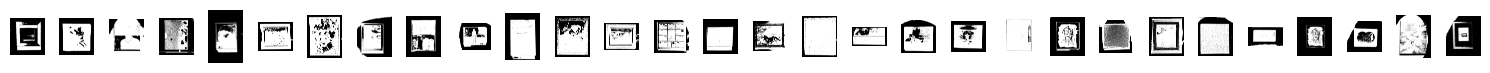

In [19]:
# Plot all masks
num_masks = len(masks)
fig, axes = plt.subplots(1, num_masks, figsize=(15, 5))  # Adjust the figsize as needed
for ax, mask in zip(axes, masks):
    ax.imshow(mask, cmap='gray')  # Use 'gray' colormap for masks
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()